# Определение степени поляризации на малых сферических частицах при помощи нейросетей


## Исходные данные
***

Загрузим данные из таблицы

In [1]:
import pandas as pd

data = pd.read_csv('data.txt', sep='\s+', header=None)
data.columns = ['x1', 'x2', 'm', 'theta', 'P1', 'P2']

x1  = data['x1'].to_numpy()
m  = data['m'].to_numpy()
x2  = data['x2'].to_numpy()
P1 = data['P1'].to_numpy()
P2 = data['P2'].to_numpy()
theta = data['theta'].to_numpy()

data

,x1,x2,m,theta,P1,P2
0,1.0,1.5,-0.01,0.0,0.12349,0.12349
1,1.0,1.5,-0.01,30.0,0.11634,0.08993
2,1.0,1.5,-0.01,60.0,0.09855,0.02890
3,1.0,1.5,-0.01,90.0,0.07791,0.00028
4,1.0,1.5,-0.01,120.0,0.06095,0.01244
...,...,...,...,...,...,...
751,1.5,1.7,-0.09,60.0,2.18423,1.40168
752,1.5,1.7,-0.09,90.0,0.91968,0.32984
753,1.5,1.7,-0.09,120.0,0.31187,0.07966
754,1.5,1.7,-0.09,150.0,0.17554,0.12959


## Функция активации
***

In [2]:
import numpy as np

def Sigmoid(z):
    return 1/(1+np.exp(-z))

## Функция подсчета cost
***

In [3]:
def cost(o, y, m):
    return np.sum((y - o)**2)/m

## Описание нейросети
***

Я создаю сеть из 2х скрытых слоёв. Следовательно у меня три матрицы весов $W^1$, $W^2$, $w^3$. И три нейрона смещения $b^1$, $b^2$, $b^3$.

Чтобы не путаться в обозначениях привожу схему работы сети:

![Схема сети](ima.png)

На последнем шаге вместо сигмойды я использую просто единичную функцию активации, поскольку сигмоида ограничена сверху 1.

Прямое распространение:

1. $z = W^1 x + b^1$
2. $h = \sigma(z)$
3. $p = W^2 h + b^2$
4. $g = \sigma (p)$
5. $y = W^3 g + b^3$
6. $C = \frac{1}{2} ||y - t||_E$, где $t$ точный резльтат.

Обратное распространение:
Для краткости введем обозначение $\frac{\partial C}{\partial v} = \bar{v}$

1. $\bar{C} = 1$
2. $\bar{y} = \bar{C}(y - t)$
3. $\bar{W^3} = \bar{y} g^T$
4. $\bar{b^3} = \bar{y} $
5. $\bar{g} = W^{3T} \bar{y}$
6. $\bar{p} = \bar{g} * \sigma' (p)$, где $*$ произведение Адамара
7. $\bar{W^2} = \bar{p} h^T $
8. $\bar{b^2} = \bar{p}$
9. $\bar{h} = W^{2T} \bar{p}$
10. $\bar{z} = \bar{h} * \sigma' (z)$
11. $\bar{W^1} = \bar{z} x^T $
12. $\bar{b^1} = \bar{z}$

In [4]:
# Запишем f' для сигмоида. Она гладкая, проблем нет.
def DiffSigmoid(z):
    return Sigmoid(z)*(1-Sigmoid(z))

In [5]:
# Сохранение numpy массивов в json
import json
from matplotlib import pyplot as plt

class NumpyArrayEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyArrayEncoder, self).default(obj)



class ANN442():
    # Инициализация сети
    def __init__(self, f, diff_F):
        
        # Размеры входного и вызодного массивов
        n_inp = 4
        n_out = 2
        
        # Вес нейрона
        self.W1 = np.random.uniform(0, 0.5, (n_inp, n_inp))
        self.W2 = np.random.uniform(0, 0.5, (n_inp, n_inp))
        self.W3 = np.random.uniform(0, 0.5, (n_out, n_inp))
        
        # Нейрон смещения
        self.b1 = np.random.uniform(0, 0.5, (n_inp))
        self.b2 = np.random.uniform(0, 0.5, (n_inp))
        self.b3 = np.random.uniform(0, 0.5, (n_out))
        
        # Задаем функцию активации (кустарно)
        #def f_(x):
        #    res = []
        #    for xi in x:
        #        res.append(f(xi))
        #    return np.array(res)
        self.f = f
        
        # Производная
        #def df_(x):
        #    res = []
        #    for xi in x:
        #        res.append(diff_F(xi))
        #    return np.array(res)
    
        self.df = diff_F
        
        
    # Прямое распространение
    def calc(self, x):
        
        z1 = self.W1 @ x + self.b1
        a1 = self.f(z1)
        
        z2 = self.W2 @ a1 + self.b2
        a2 = self.f(z2)

        z3 = self.W3 @ a2 + self.b3
        a3 = z3
        
        return a3, [z1, z2, z3], [x, a1, a2, a3]
    
    # Обучение нейросети
    def eval_(self, xdata, ydata, N_epoch=1000, speed_learn=0.1):
        
        plt.figure()
        t = 0
        e_loss = 0
        
        for _ in range(N_epoch):
        
            for x_, y_ in zip(xdata, ydata):
                o, z_s, a_s = self.calc(x_)
                e_loss += cost(o, y_, 2)
                z, p, y    = z_s
                x, h, g, _ = a_s
                
                # Расчет обратного распространения
                
                dL  = 1
                dy  = dL*(o - y_)
                dy  = np.reshape(dy, (2,1))
                g   = np.reshape(g , (4,1))
                
                dW3 = dy @  np.transpose(g)
                db3 = dy
                
                p   = np.reshape(p, (4,1))
                h   = np.reshape(h, (4,1))
                
                dg  = np.transpose(self.W3) @ dy
                dp  = dg * self.df(p)
                dW2 = dp @ np.transpose(h)
                db2  = dp
                
                z   = np.reshape(z, (4,1))
                x   = np.reshape(x, (4,1))
                
                dh  = np.transpose(self.W2) @ dp 
                dz  = dh * self.df(z)
                dW1 = dz @ np.transpose(x)
                db1 = dz
                

                self.W1 -= speed_learn*dW1
                self.W2 -= speed_learn*dW2
                self.W3 -= speed_learn*dW3
                
                self.b1 -= speed_learn*np.reshape(db1, 4)
                self.b2 -= speed_learn*np.reshape(db2, 4)
                self.b3 -= speed_learn*np.reshape(db3, 2)
            
            # Построение графика обучения
            plt.plot(t, e_loss, 'ob')
            
            e_loss = 0
            t += 1
        print(t, e_loss)
        plt.ylim(0,)
        plt.xlabel('t epoch')
        plt.ylabel('Cost')
        plt.show()
        return
    
    # Сохранение весов и смещения в json файл
    def save(self, fname):
        with open(fname, 'w') as f:
            s = dict()
            
            s['W1'] = json.dumps(self.W1, cls=NumpyArrayEncoder)
            s['W2'] = json.dumps(self.W2, cls=NumpyArrayEncoder)
            s['W3'] = json.dumps(self.W3, cls=NumpyArrayEncoder)
            
            s['b1'] = json.dumps(self.b1, cls=NumpyArrayEncoder)
            s['b2'] = json.dumps(self.b2, cls=NumpyArrayEncoder)
            s['b3'] = json.dumps(self.b3, cls=NumpyArrayEncoder)
            
            json.dump(s, f)
        


20000 0


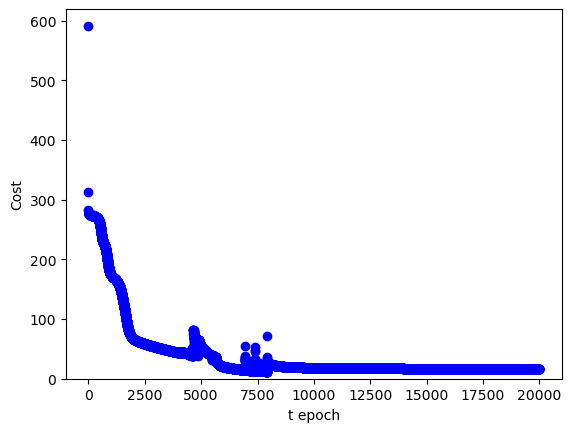

In [6]:
# Инициализация сети                
my_ann = ANN442(Sigmoid, DiffSigmoid)

# Подготовка данных
X = [[a, b, c, d] for a, b, c, d in zip(x1, x2, m, theta)]
Y = [[a, b] for a, b in zip(P1, P2)]

# Обучение. Число эпох и скорость обучения подобраны эмпирически
my_ann.eval_(X, Y, 20_000, 0.0005)

# Сохранение результатов
my_ann.save('save_ann.json')

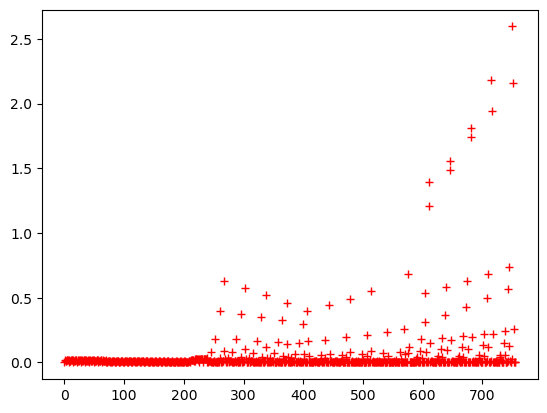

mean= 0.056626463748407185


In [7]:
e_losses = []
plt.figure()
for x, y in zip(X, Y):
    o, _, _ = my_ann.calc(x)
    e_loss = cost(o, y, 2)
    #print(e_loss)
    e_losses.append(e_loss)
plt.plot(e_losses,'+r')
plt.show()
print('mean=', np.mean(e_losses))